# Figure 1
---

In [1]:
#%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import grimpfunc as grimp
import nisardev as nisar
import panel as pn
pn.extension()
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)
import matplotlib.gridspec as gridspec

In [2]:
# Set path for gdal 
env = dict(GDAL_HTTP_COOKIEFILE = os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR = os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)
# Get login
myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


## Product Definitions

In [3]:
products = ['S1_Annual','S1_Quarterly', 'S1_Monthly', 'S1_6day', 'TSX', 'Opt']
nsidcNames = {'S1_Annual': 'NSIDC-0725','S1_Quarterly': 'NSIDC-0727' , 'S1_Monthly': 'NSIDC-0731', 'S1_6day': 'NSIDC-0766', 'TSX': 'NSIDC-0481', 'Opt': 'NSIDC-0646'}
prodDate = {'S1_Annual': {'format': '%d%b%y', 'index1': 4, 'index2': 5, },
            'S1_Quarterly': {'format': '%d%b%y', 'index1': 4, 'index2': 5},
            'S1_Monthly': {'format': '%d%b%y', 'index1': 4, 'index2': 5},
            'S1_6day': {'format': '%d%b%y', 'index1': 4, 'index2': 5},
            'TSX': {'format': '%d%b%y', 'index1': 2, 'index2': 3},
            'Opt': {'format': '%Y-%m', 'index1': 2, 'index2': None}}
prodReplace =  {'S1_Annual':  'vv',
            'S1_Quarterly':  'vv',
            'S1_Monthly': 'vv',
            'S1_6day':  'vv',
            'TSX': 'vv',
            'Opt': 'vx'}

## Get Data

Point to plot.

In [4]:
points = {'Jak': {'xc': -180.6,'yc': -2278.6},
          'Helheim': {'xc': 303.3,'yc': -2577.3},
          'Kang': {'xc':487.3,'yc': -2290.3}}
#xcHelheim, ycHelheim = 303.3, -2577.3
#xcKang, ycKang = 487.3, -2577.3
dx, dy = 5000, 5000
xyBounds = {}
for glacier in ['Jak', 'Helheim', 'Kang']:
     xyBounds[glacier] = dict(zip(['minx', 'miny', 'maxx', 'maxy'], [points[glacier]['xc'] * 1000 - dx, points[glacier]['yc'] * 1000 - dy,
                                                                     points[glacier]['xc'] * 1000 + dx, points[glacier]['yc'] * 1000 + dy]))
xyBounds;

Find products in catalog.

In [5]:
glacierData = {}
for glacier, box in zip(['Jak', 'Helheim', 'Kang'], ['W69.10N', 'E66.50N', 'E68.80N']):
    glacierData[glacier] = {}
# Search catalog for all products
    prodFilter = {'S1_Annual': None,'S1_Quarterly': None , 'S1_Monthly': None, 'S1_6day': None, 'TSX': box, 'Opt': box}
    for product in products:
        myUrls = grimp.cmrUrls(mode='subsetter')  # mode image restricts search to the image products
        myUrls.initialSearch(firstDate='1984-01-01', lastDate='2022-05-01', product=nsidcNames[product], productFilter=prodFilter[product]) 
        glacierData[glacier][f'{product}Cogs'] =  myUrls.getCogs(replace=prodReplace[product], removeTiff=True)
        print(f'{glacier} {product} {len(glacierData[glacier][f"{product}Cogs"])}')


Jak S1_Annual 6
Jak S1_Quarterly 26
Jak S1_Monthly 78
Jak S1_6day 318
Jak TSX 562
Jak Opt 221
Helheim S1_Annual 6
Helheim S1_Quarterly 26
Helheim S1_Monthly 78
Helheim S1_6day 318
Helheim TSX 201
Helheim Opt 224
Kang S1_Annual 6
Kang S1_Quarterly 26
Kang S1_Monthly 78
Kang S1_6day 318
Kang TSX 202
Kang Opt 234


Download products or read the netcdf from a prior download.

In [6]:
%%time
for glacier in ['Jak', 'Helheim', 'Kang']:
    for product  in products:
        velSeries = f'{product}Series'
        localCopy = f'{glacier}-{velSeries}.nc'
        glacierData[glacier][velSeries] = nisar.nisarVelSeries()
        if os.path.exists(localCopy):
            glacierData[glacier][velSeries].readSeriesFromNetCDF(localCopy)
        else:
            glacierData[glacier][velSeries].readSeriesFromTiff(JakData[f'{product}Cogs'], url=True, readSpeed=False, 
                                                  index1=prodDate[product]['index1'], index2=prodDate[product]['index2'], dateFormat=prodDate[product]['format'])
            glacierData[glacier][velSeries].subSetVel(xyBounds[glacier])
            glacierData[glacier][velSeries].loadRemote()
            glacierData[glacier][velSeries].toNetCDF(localCopy)
        velPoint = f'{product}Point'
        glacierData[glacier][velPoint] = glacierData[glacier][velSeries].interp(points[glacier]['xc'], points[glacier]['yc'], units='km', returnXR=True)

CPU times: user 767 ms, sys: 290 ms, total: 1.06 s
Wall time: 2.01 s


## Overview Image

In [7]:
overViewUrl = glacierData['Jak'][f'S1_AnnualCogs'][-1:]
overViewUrl

['https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.003/2019.12.01/GL_vel_mosaic_Annual_01Dec19_30Nov20_*_v03.0']

In [8]:
myOverview = nisar.nisarVelSeries() # Create Series
myOverview.readSeriesFromTiff(overViewUrl , url=True, readSpeed=False, overviewLevel=1)  # readSpeed=False computes speed from vx, vy rather than downloading
myOverview.loadRemote()
myOverview.xr;  # Add semicolon after to suppress output

[########################################] | 100% Completed |  6.3s


## Generate Plot

/var/folders/t4/hk6zkh0n4xzbb1pvcf3t2sg40003lv/T/ipykernel_30243/193980039.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


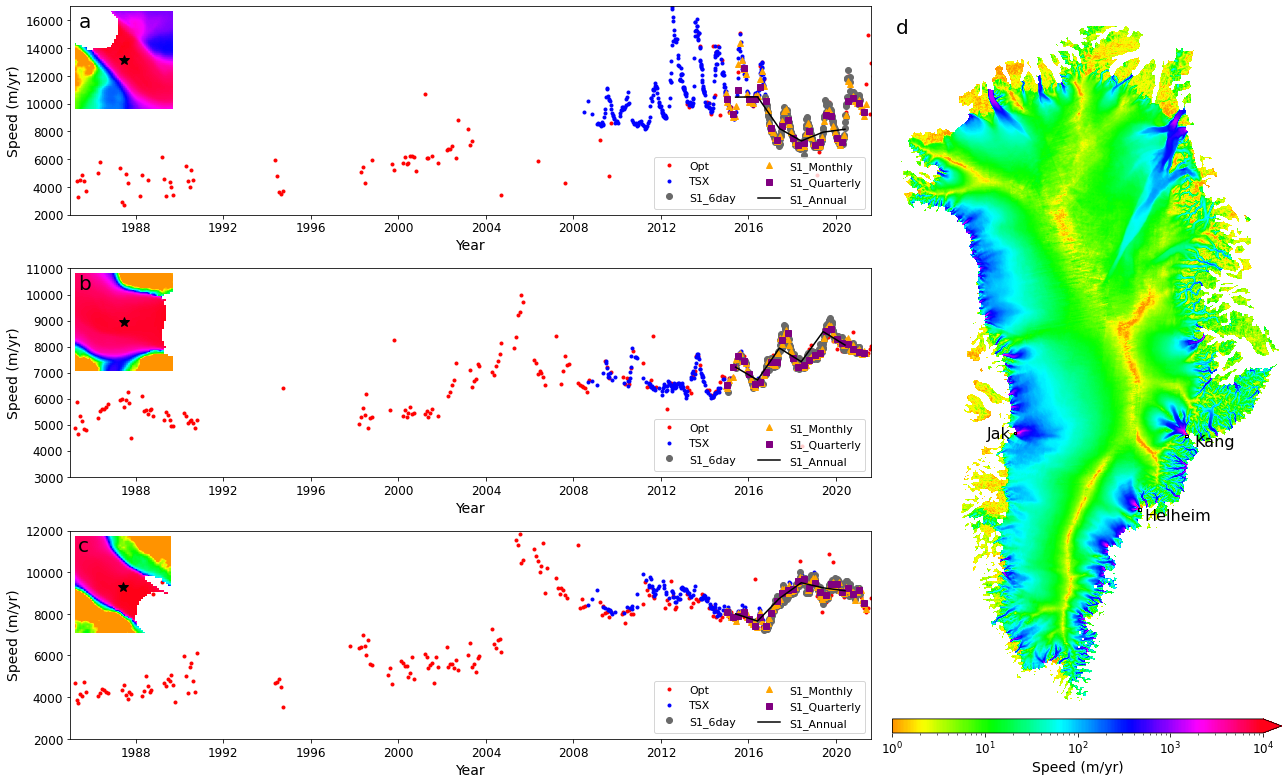

In [29]:
fig = plt.figure(figsize=(18, 11))
gs = gridspec.GridSpec(6, 6)
#axJak = plt.subplot(gs[0:2, 0:])
n = 4
height = 1.35
myAxes = {'Jak': plt.subplot(gs[0:2, 0:n]),
          'Helheim': plt.subplot(gs[2:4, 0:n]),
          'Kang': plt.subplot(gs[4:, 0:n])}
mapAxes = plt.subplot(gs[:, n:])

myLimits={'Jak': (2000, 17000),
          'Helheim':  (3000, 11000),
          'Kang': (2000, 12000)}
#
plotOrder = ['Opt', 'TSX',  'S1_6day', 'S1_Monthly','S1_Quarterly', 'S1_Annual']
#
plotSym = {'Opt': {'sym': '.', 'color': 'r'},
           'TSX': {'sym': '.', 'color': 'b'},
           'S1_6day': {'sym': 'o', 'color': 'dimgray'},
           'S1_Monthly': {'sym': '^', 'color': 'orange'},
           'S1_Quarterly': {'sym': 's', 'color': 'purple'},
           'S1_Annual': {'sym': '-', 'color': 'k'}}
xlabelOffset = {'Jak': -110, 'Helheim': 20, 'Kang': 30}
ylabelOffset = {'Jak': -20, 'Helheim': -40, 'Kang': -40}
#
myOverview.displayVelForDate(date='2020-01-01', ax=mapAxes, colorBar=True, axisOff=True, units='km', title='', scale='log', vmin=1, vmax=10000, colorBarPosition='bottom', colorBarSize='2%') 
mapAxes.text(0.01, 0.97, 'd', transform=mapAxes.transAxes, fontsize=20)
#
for myGlacier in glacierData.keys():
    myData = glacierData[myGlacier]
    for product  in plotOrder:
        #JakData[velSeries].displayVelForDate(date='2018-07-30', band='vv', ax=ax, units='km', vmax=14000, colorBarPosition='top')
        #ax.plot(xc, yc, 'r*')
        xbox = np.array([xyBounds[myGlacier][x] * 0.001 for x in ['minx', 'minx', 'maxx', 'maxx', 'minx']]) 
        ybox = np.array([xyBounds[myGlacier][y] * 0.001 for y in ['miny', 'maxy', 'maxy', 'miny', 'miny']])
        point = f'{product}Point'
        myAxes[myGlacier].plot(myData[point].time, myData[point].sel(band='vv'), plotSym[product]['sym'], color=plotSym[product]['color'], label=product)
        #print(xbox, ybox)
    mapAxes.plot(xbox, ybox, '-', linewidth=1, color='k')
   
    myAxes[myGlacier].set_ylim(myLimits[myGlacier])
    myAxes[myGlacier].set_xlim([datetime(1985,1,1), datetime(2021,8,1)])
   
    myAxes[myGlacier].legend(loc='lower right', ncol=2, fontsize=11) 
    myAxes[myGlacier].tick_params(axis='both', labelsize=12)
    myAxes[myGlacier].set_ylabel('Speed (m/yr)', fontsize=14)
    myAxes[myGlacier].set_xlabel('Year', fontsize=14)
    mapAxes.text(points[myGlacier]['xc'] + xlabelOffset[myGlacier], points[myGlacier]['yc'] + ylabelOffset[myGlacier], myGlacier, fontsize=16) #, transform=mapAxes.transAxes)     
#
    axInset = inset_axes(myAxes[myGlacier], width=height * myData['S1_AnnualSeries'].sx/myData['S1_AnnualSeries'].sy, height=height, loc=2)
    myData['S1_AnnualSeries'].displayVelForDate(date='2020-01-01', ax=axInset, colorBar=False, axisOff=True, units='m', title='',scale='log', vmin=1, vmax=10000,) #cmap=plt.cm.gray.with_extremes(bad=(.4,0.4,.4)),
    axInset.plot(myData['S1_AnnualPoint'].x, myData['S1_AnnualPoint'].y, 'k*', markersize=10)
    axInset.text(0.01, 0.9, {'Jak': 'a', 'Helheim': 'b', 'Kang': 'c'}[myGlacier], fontsize=20, transform=myAxes[myGlacier].transAxes)


fig.tight_layout()
fig.savefig('Figure1.jpg', dpi=200)

0 2008-05-16
1 2008-06-15
2 2008-07-16
3 2008-08-16
4 2009-03-16
5 2009-04-15
6 2009-05-16
7 2009-06-15
8 2009-07-16
9 2009-08-16
10 2009-09-15
11 2010-04-15


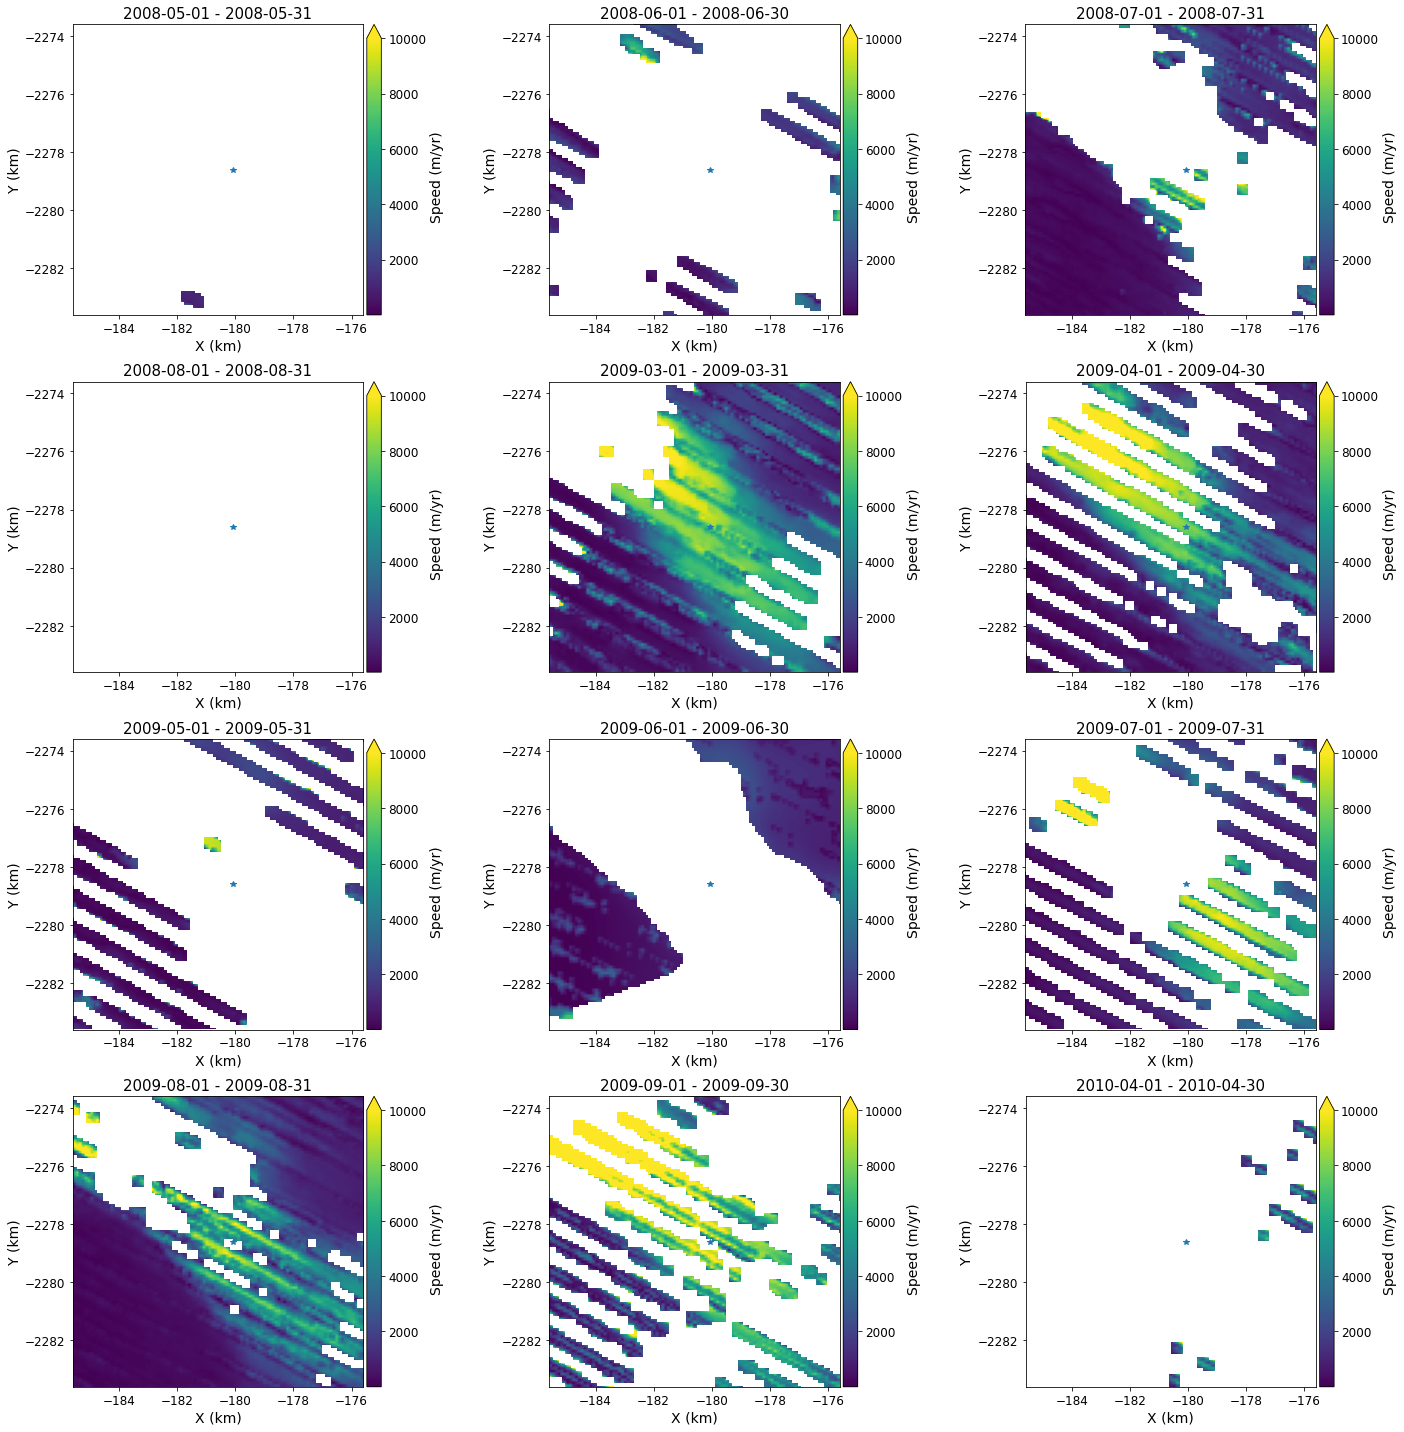

In [95]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
i =0
for date in glacierData['Jak']['OptSeries'].time:
    #print(f'{month:02d}-02d')
    #print(datetime.datetime(2005,1,1), date)
    #print(date)
    if date > datetime(2008,1,1):
        print(i, date.strftime('%Y-%m-%d'))
        glacierData['Jak']['OptSeries'].displayVelForDate(date=date.strftime('%Y-%m-%d'), ax=axes.flatten()[i], colorBar=True, axisOff=False, units='km',scale='linear', autoScale=False, vmin=1, vmax=10000, midDate=False)
        #ax.plot(glacierData['Jak']['S1_AnnualPoint'].x * 0.001, glacierData['Jak']['S1_AnnualPoint'].y * 0.001, 'k*', markersize=10)
        axes.flatten()[i].plot(-180.077, -2278.605,'*')
        i = i + 1
        if i > 11:
            break
fig.tight_layout()

In [25]:
glacierData['Jak']['S1_AnnualPoint'].y.data

array([-2278600.])

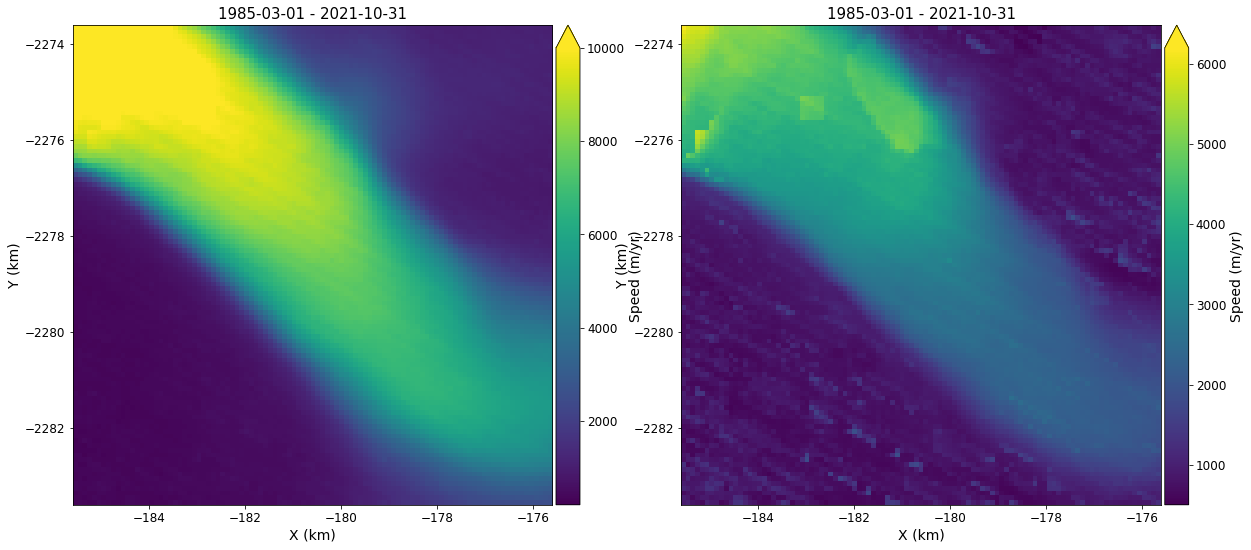

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
mean = glacierData['Jak']['OptSeries'].mean()
std = glacierData['Jak']['OptSeries'].stdev()
anomaly = glacierData['Jak']['OptSeries'].anomaly()
mean.displayVelForDate(date=f'2009-{month:02d}-01', ax=axes[0], colorBar=True, axisOff=False, units='km',scale='linear', vmin=1, vmax=10000, midDate=False)
std.displayVelForDate(date=f'2009-{month:02d}-01', ax=axes[1], colorBar=True, axisOff=False, units='km',scale='linear', vmin=1, vmax=10000, midDate=False)

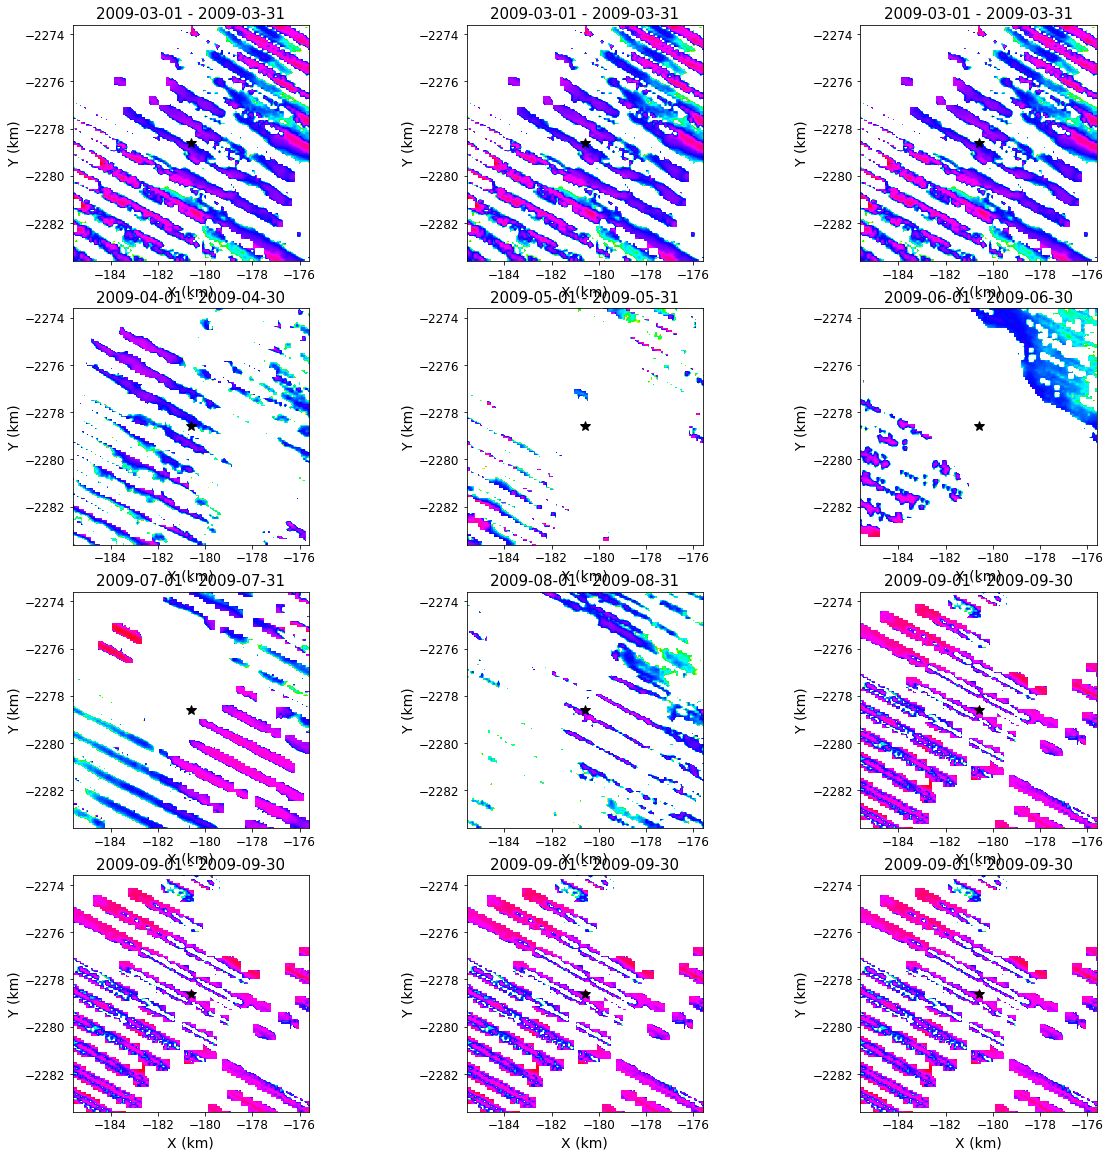

In [56]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
for month, ax  in zip(range(1, 13), axes.flatten()):
    #print(f'{month:02d}-02d')
    anomaly.displayVelForDate(date=f'2009-{month:02d}-01', ax=ax, colorBar=False, axisOff=False, units='km',scale='log', vmin=1, vmax=10000, midDate=False)
    ax.plot(glacierData['Jak']['S1_AnnualPoint'].x * 0.001, glacierData['Jak']['S1_AnnualPoint'].y * 0.001, 'k*', markersize=10)